## Augmentation

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist

In [3]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train, X_test = X_train[..., tf.newaxis]/255., X_test[..., tf.newaxis]/255.

In [5]:
image = X_train[0]
image.shape

(28, 28, 1)

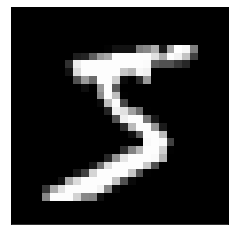

In [11]:
plt.imshow(image[..., 0], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

### Image Data Generator

클래스 객체(함수와 비슷)를 만들어 놓고, 거기에 image(X)를 flow해주는 방식

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True, #좌우 반전
)

(N, H, W, C) 형태를 맞춰줘야 한다 (이미지 장 수 정보 추가)

In [19]:
inputs = X_train[0]
inputs = inputs[tf.newaxis, ...]

In [20]:
datagen.flow(inputs)

flow를 통해, for문 객체를 얻었다고 보면 됨

#### Iterator?

for문 처럼 움직이는 애들

iter() : (tf 객체에서 파이썬 객체로 바꿔서) 함수 실행  
next() : 옆으로 한 칸 움직이겠다
flow() : 객체 생성

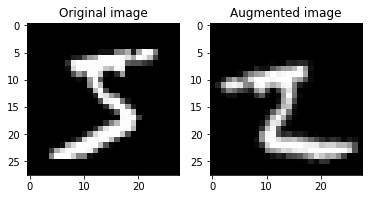

In [22]:
img_iterator = datagen.flow(inputs)
image = next(iter(img_iterator))

plt.subplot(121)
plt.imshow(np.squeeze(inputs), 'gray')
plt.title('Original image')

plt.subplot(122)
plt.imshow(np.squeeze(image), 'gray')
plt.title('Augmented image')
plt.show()

np.squeeze() : 개수가 1인 차원 없애기

### Image Data Generator 옵션

* width_shift_range : 좌우 이동 범위 설정
* height_shift_range : 상하 이동 범위 설정
* brightness_range : 밝기 조절 설정
* zoom_range : 확대 / 축소 범위 설정
* horizontal_flip : 좌우반전 여부( bool )
* vertical_flip : 상하반전 여부( bool )
* **rescale : 픽셀 전처리 단위 설정**
* preprocessing_function : opencv 등 외부 라이브러리를 이용한 전처리 할 때 사용

주의! train data에 rescale했으면, 반드시 test data에도 rescale해줘라

In [25]:
train_datagen = ImageDataGenerator(
    zoom_range=0.7,
    rescale=1./255., # 픽셀 단위 조정
)

test_datagen = ImageDataGenerator(
    rescale=1./255.,
)

## Callback

1 epoch 학습이 끝날 때 마다 수행할 기능

In [26]:
from tensorflow.keras import layers
import tensorflow as tf

input_shape = (28, 28, 1)
num_classes = 10

inputs = layers.Input(shape=input_shape)

# Feature Extraction
net = layers.Conv2D(32, 3, padding='SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(64, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64, 3, padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2, 2))(net)
net = layers.Dropout(0.25)(net)

# Fully Connected
net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.25)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [29]:
loss_func = tf.keras.losses.sparse_categorical_crossentropy
metrics = ['acc']
optm = tf.keras.optimizers.RMSprop()

model.compile(
    loss = loss_func,
    optimizer = optm,
    metrics = metrics
)

### Tensor board Setting

계산 그래프에 흘러가는 tensor를 보여주는 callback 도구

In [31]:
from datetime import datetime
import os

#os join 기능을 활용해 directory위치와 파일명을 동시에 지정한다
logdir = os.path.join("logs", datetime.now().strftime('%Y%m%d-%H%M%S')) 

In [33]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard = TensorBoard(
    log_dir = logdir, #로깅할 디렉토리 설정
    write_graph = True,
    write_images = True,
    histogram_freq = 1 # 1 epoch 당 기록
)

### TB in Notebook (Magic Command)

%load_ext tensorboard : 노트북 안에서 TB 보여줘
%tensorboard --logdir --port 8080 : 우리가 만든 logdir에 있는 logs 실행해줘

#### histogram에서 epoch이 진행될수록 분포가 정규분포를 따르지 않고 평평해지는데?????

그 이유?!
overfitting일어나서 로스 올라가자너 ㅎㅎ 그니까 그렇지

In [36]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
%tensorboard --logdir logs --port 8008

In [39]:
model.fit(X_train,
         y_train,
         validation_split=0.2,
         batch_size=32,
         epochs=30,
         callbacks=[tensorboard])

Epoch 1/30
1500/1500 [==============================] - 24s 11ms/step - loss: 0.1443 - acc: 0.9556 - val_loss: 0.0448 - val_acc: 0.9866
Epoch 2/30
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0620 - acc: 0.9820 - val_loss: 0.0646 - val_acc: 0.9837
Epoch 3/30
1500/1500 [==============================] - 19s 12ms/step - loss: 0.0514 - acc: 0.9848 - val_loss: 0.0402 - val_acc: 0.9898
Epoch 4/30
1500/1500 [==============================] - 19s 12ms/step - loss: 0.0483 - acc: 0.9868 - val_loss: 0.0338 - val_acc: 0.9909
Epoch 5/30
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0462 - acc: 0.9872 - val_loss: 0.0297 - val_acc: 0.9920
Epoch 6/30
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0461 - acc: 0.9869 - val_loss: 0.0382 - val_acc: 0.9891
Epoch 7/30
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0450 - acc: 0.9879 - val_loss: 0.0472 - val_acc: 0.9879
Epoch 8/30
1500/1500 [==========================

### Early Stopping

지정 횟수동안 성능 개선 없으면 학습 중지

### Model Checkpoint

best model을 '.h5'로 저장 (덮어쓰기)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
es = EarlyStopping(
    monitor='val_loss', #val_loss를 감시
    mode='min',
    verbose=1, #로그 레벨
    patience=4 #epoch 몇 번 까지 지켜볼까?
)

mc = ModelCheckpoint(
    'best_model.h5',
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [48]:
model.fit(X_train,
         y_train,
         validation_split=0.2,
         epochs=100,
         batch_size=32,
         callbacks=[es, mc]
)

Epoch 1/100
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0910 - acc: 0.9798 - val_loss: 0.0446 - val_acc: 0.9904

Epoch 00001: val_acc improved from -inf to 0.99042, saving model to best_model.h5
Epoch 2/100
1500/1500 [==============================] - 19s 12ms/step - loss: 0.0887 - acc: 0.9802 - val_loss: 0.0502 - val_acc: 0.9889

Epoch 00002: val_acc did not improve from 0.99042
Epoch 3/100
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0975 - acc: 0.9792 - val_loss: 0.0615 - val_acc: 0.9836

Epoch 00003: val_acc did not improve from 0.99042
Epoch 4/100
1500/1500 [==============================] - 17s 12ms/step - loss: 0.0929 - acc: 0.9804 - val_loss: 0.0617 - val_acc: 0.9893

Epoch 00004: val_acc did not improve from 0.99042
Epoch 5/100
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0955 - acc: 0.9801 - val_loss: 0.0560 - val_acc: 0.9866

Epoch 00005: val_acc did not improve from 0.99042
Epoch 00005: early stopping
